In [26]:
import os

imdb_dir = 'C:\\Users\\rocky\\Desktop\\nlp\\IMDB\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

texts = []
labels = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000        #only care about the 10000 most frequently used words 

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [30]:
glove_dir = 'C:\\Users\\rocky\\Desktop\\nlp\\IMDB\\glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [31]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [34]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 101ms/step - loss: 1.4738 - acc: 0.4650 - val_loss: 0.6958 - val_acc: 0.5283
Epoch 2/10
7/7 [==============================] - 0s 82ms/step - loss: 0.5988 - acc: 0.6850 - val_loss: 0.6912 - val_acc: 0.5505
Epoch 3/10
7/7 [==============================] - 0s 80ms/step - loss: 0.4025 - acc: 0.8550 - val_loss: 1.1255 - val_acc: 0.4998
Epoch 4/10
7/7 [==============================] - 1s 97ms/step - loss: 0.3352 - acc: 0.8300 - val_loss: 0.8171 - val_acc: 0.5158
Epoch 5/10
7/7 [==============================] - 1s 89ms/step - loss: 0.2046 - acc: 0.9500 - val_loss: 1.5386 - val_acc: 0.4999
Epoch 6/10
7/7 [==============================] - 1s 86ms/step - loss: 0.2016 - acc: 0.9400 - val_loss: 0.7945 - val_acc: 0.5389
Epoch 7/10
7/7 [==============================] - 0s 80ms/step - loss: 0.0897 - acc: 0.9950 - val_loss: 1.1027 - val_acc: 0.5098
Epoch 8/10
7/7 [==============================] - 0s 79ms/step - loss: 0.0991 - acc: 0.9900 - va

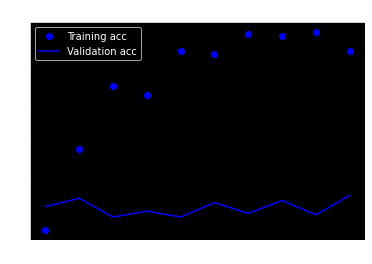

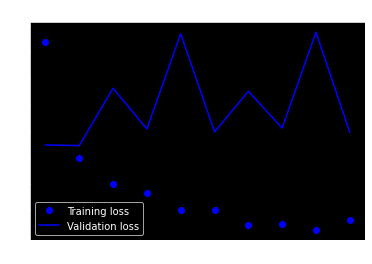

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()